In [1]:
def interpolate_mask(flux,mask):
    new_flux = np.zeros(flux.shape)
    new_flux = flux
    for j,mask_row in enumerate(mask):
        cnt = 0
        for i, mask_ele in enumerate(mask_row):
            if mask_ele != 0:
                cnt += 1
            if mask_ele == 0 and cnt != 0:
                new_flux[j,i-cnt:i] = np.linspace(flux[j,i-cnt-1],flux[j,i],cnt+2)[1:-1]
                cnt = 0
    return new_flux

class Dataset:
    def __init__(self,xs,ys,yerr,mask):
        self.xs = xs
        self.ys = ys
        self.yerr = yerr
        self.mask = mask
            
        self.yivar = 1/self.yerr**2
            
    def set_mask(self,y_val,yerr_val):
        self.ys[self.mask] = y_val
        self.yerr[self.mask] = yerr_val
        
        self.yivar = 1/self.yerr**2
    
    def __getitem__(self,i):
        return Dataset(self.xs[i,:],self.ys[i,:],self.yerr[i,:],self.mask[i,:])
    
    def from_flux(wave,flux,ferr,mask,normalize=None,nargs=[]):
        if normalize is None:
            nargs = [80]
            normalize = scipy.ndimage.gaussian_filter
        xs = np.log(wave.to(u.Angstrom).value)
        flux_interp = interpolate_mask(flux,mask)

        flux_norm = np.empty(flux.shape)
        for i in range(flux.shape[0]):
            flux_norm[i,:] = normalize(flux_interp[i,:],*nargs)
        ys = np.log(flux_interp/flux_norm)
        yerr = ferr/flux_interp
        return Dataset(xs, ys, yerr, mask)

In [2]:
import numpy as np

In [3]:
xs = np.outer(np.ones((3)),np.linspace(0,1))
ys = np.outer(np.ones((3)),np.linspace(0,1))
yerr = np.outer(np.ones((3)),np.zeros(xs.shape))
mask = np.zeros(xs.shape)

data = Dataset(xs,ys,yerr,mask)

/state/partition1/job-12734138/ipykernel_148355/3241505425.py:21: RuntimeWarning: divide by zero encountered in true_divide
  self.yivar = 1/self.yerr**2


In [4]:
eval_data = data[:3]

/state/partition1/job-12734138/ipykernel_148355/3241505425.py:21: RuntimeWarning: divide by zero encountered in true_divide
  self.yivar = 1/self.yerr**2


In [5]:
print(eval_data.ys)

[[0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
  0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
  0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
  0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
  0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
  0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
  0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
  0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
  0.97959184 1.        ]
 [0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
  0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
  0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
  0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
  0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
  0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
  0.73469388 0.75510204 0

In [6]:
def interpolate_mask(flux,mask):
    new_flux = np.zeros(flux.shape)
    new_flux = flux
    for j,mask_row in enumerate(mask):
        cnt = 0
        for i, mask_ele in enumerate(mask_row):
            if mask_ele != 0:
                cnt += 1
            if mask_ele == 0 and cnt != 0:
                new_flux[j,i-cnt:i] = np.linspace(flux[j,i-cnt-1],flux[j,i],cnt+2)[1:-1]
                cnt = 0
    return new_flux

In [7]:
import scipy.ndimage
# scipy.ndimage.gaussian_filter(flux,sigma=sigma)

In [8]:
def clean_convert_data(wave,flux,ferr,mask,normalize=None,nargs=[]):
    if normalize is None:
        nargs = [80]
        normalize = scipy.ndimage.gaussian_filter
    xs = np.log(wave.to(u.Angstrom).value)
    flux_interp = interpolate_mask(flux,mask)
    
    flux_norm = np.empty(flux.shape)
    for i in range(flux.shape[0]):
        flux_norm[i,:] = normalize(flux_interp[i,:],*nargs)
    ys = np.log(flux_interp/flux_norm)
    yerr = ferr/flux_interp
    return xs, ys, yerr

In [9]:
import astropy.io.fits
import astropy.units as u

In [10]:
star_data = astropy.io.fits.open('../data/2M12504515+1133371.fits')

In [11]:
star_data[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =               104456 / length of dimension 1                          
NAXIS2  =                   52 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'wavelength'                                                          
TFORM1  = '6144D   '                                                            
TDIM1   = '(6144)  '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = '6144E   '        

In [12]:
flux, wave, ferr, mask = star_data[1].data['flux'], star_data[1].data['wavelength'] * u.Angstrom, star_data[1].data['flux_err'], star_data[1].data['mask']

In [13]:
import matplotlib.pyplot as plt

In [14]:
xs,ys,yerr = clean_convert_data(wave,flux,ferr,mask,normalize=scipy.ndimage.gaussian_filter,nargs=[40,0])
ys[mask], yerr[mask] = 0.0, 10.0

/state/partition1/job-12734138/ipykernel_148355/2399338887.py:11: RuntimeWarning: divide by zero encountered in log
  ys = np.log(flux_interp/flux_norm)
/state/partition1/job-12734138/ipykernel_148355/2399338887.py:11: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux_interp/flux_norm)
/state/partition1/job-12734138/ipykernel_148355/2399338887.py:12: RuntimeWarning: divide by zero encountered in true_divide
  yerr = ferr/flux_interp


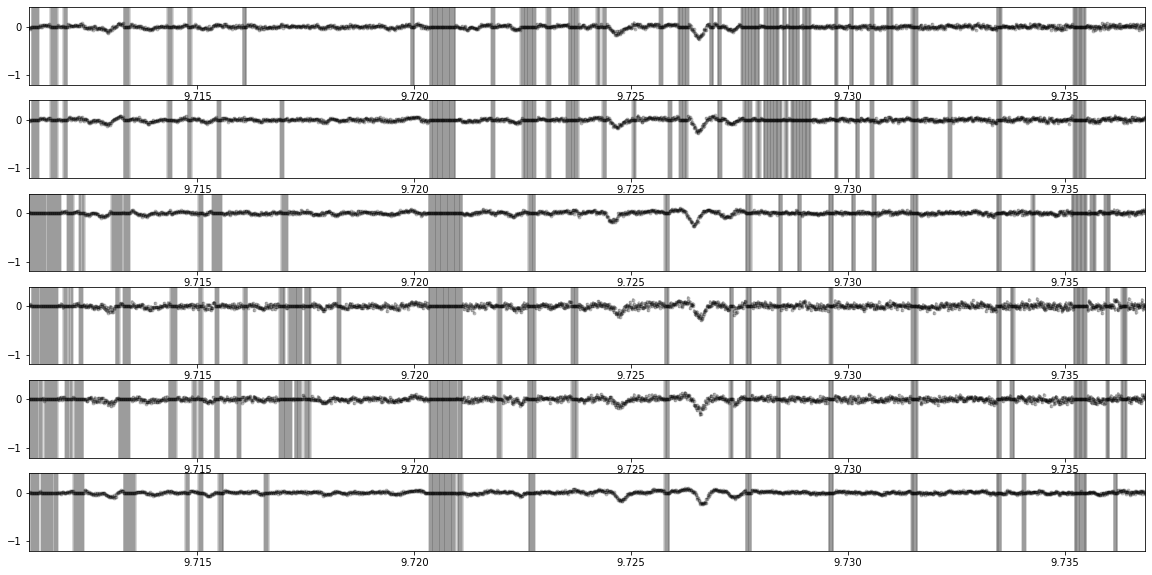

In [15]:
epoches = [17,18,30,41,43,51]
fig, axes = plt.subplots(len(epoches),figsize=(20,10))
for i,plt_epoch in enumerate(epoches):
    axes[i].errorbar(xs[plt_epoch,:],ys[plt_epoch,:],yerr[plt_epoch,:],fmt='.k',zorder=1,alpha=0.2)
    axes[i].set_xlim(np.log(16500),np.log(16930))
    axes[i].set_ylim(-1.2,0.4)
plt.show()

<h2> Create New Dataset </h2>
create this new ds and split into evaluation and test data.

In [16]:
all_data = Dataset.from_flux(wave,flux,ferr,mask)
all_data.set_mask(0.0,10.0)

/state/partition1/job-12734138/ipykernel_148355/3241505425.py:42: RuntimeWarning: divide by zero encountered in log
  ys = np.log(flux_interp/flux_norm)
/state/partition1/job-12734138/ipykernel_148355/3241505425.py:42: RuntimeWarning: invalid value encountered in log
  ys = np.log(flux_interp/flux_norm)
/state/partition1/job-12734138/ipykernel_148355/3241505425.py:43: RuntimeWarning: divide by zero encountered in true_divide
  yerr = ferr/flux_interp


In [17]:
import sys
sys.path.insert(0,'..')

In [18]:
import jabble.model
import astropy.coordinates as coord
import astropy.time as atime
import astropy.constants as const

In [19]:
times = atime.Time(star_data[1].data['BJD'], format='jd', scale='tdb')
location = coord.EarthLocation.of_site('APO')
target = coord.SkyCoord.from_name('2MASS J12504515+1133371',parse=True)

In [20]:
bc = target.radial_velocity_correction(obstime=times,location=location).to(u.km/u.s)

In [21]:
def train_cycle(model,data,loss,indices,fit1_inds,fit2_inds,maxiter1,maxiter2):
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,maxiter1,loss_ind=indices)
    model.fix()
    
    # Grid Search
    print('grid searching')
    vel_width = 5 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bc,velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    model[0].p = x_min
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    for ind in fit2_inds:
        model.fit(*ind)
    res2 = model.optimize(loss,data,maxiter2,loss_ind=indices)
    return model

In [22]:
def eval_cycle(model,data,loss,indices,maxiter):
    print('grid searching')
    vel_width = 5 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bc,velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    model[0].p = x_min
    
    # Fitting Round 2
    print('eval')
    model.fix()
    model.fit(0)
    res2 = model.optimize(loss,data,maxiter,loss_ind=indices)
    
    return model

In [41]:
def cross_validation(data,loss,train_cycle,eval_cycle):
    maxiter1 = 256
    maxiter2 = 256
    
    evaliter = 256
    
    velocities = np.zeros(data.ys.shape[0]) * u.m/u.s
    
    indices = list(range(data.ys.shape[0]))
    for i in indices:
        resolution = 4*33_500
        init_shifts = jabble.dataset.shifts(bc)
        vel_padding = 20 * u.km/u.s
        x_grid = jabble.model.create_x_grid(all_data.xs,vel_padding,resolution)
        
        model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
        
        train_ind = indices.copy()
        train_ind.remove(i)
        eval_ind = [i]
        
        model = train_cycle(model,data,loss,train_ind,[[1]],[[0],[1]],maxiter1,maxiter2)
        model = eval_cycle(model,data,loss,eval_ind,evaliter)
        
        velocities[i] = jabble.dataset.velocityfromshift(model[0].p[i])
    return velocities

In [42]:
indices = list(range(3) )
for i in indices:
    print(i)
    x = indices.copy()
    x.remove(i)
#     print(indices.remove(i))
    print(x)

0
[1, 2]
1
[0, 2]
2
[0, 1]


In [43]:
import jabble.loss

In [44]:
loss = jabble.loss.ChiSquare()

In [45]:
velocities = cross_validation(all_data,loss,train_cycle,eval_cycle)

fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    113    137      1     0     0   3.456D+01   4.946D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 2
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 2
epch 39: min 0
minimum

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     10     59      2     0     0   2.264D+08   4.789D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 2
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 2
epch 39: min 0
minimum

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.281D+07   9.871D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     92    113      1     0     0   2.092D+01   4.960D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     27     88      2     0     0   1.581D+08   4.753D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    149    178      1     0     0   1.707D+01   4.959D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     14     71      2     0     0   2.682D+08   5.390D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38:

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   2.832D+07   8.578D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    135    158      1     0     0   1.790D+01   4.966D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 2
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 2
epch 39: min 0
minimum

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     10     59      2     0     0   3.738D+08   4.813D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 2
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 2
epch 39: min 0
minimum

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   9.659D+06   8.149D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    119    139      1     0     0   3.317D+01   4.992D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     12     61      2     0     0   3.867D+08   5.304D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   5.369D+06   5.984D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    113    137      1     0     0   1.340D+01   5.004D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      6     56      2     0     0   7.100D+08   5.442D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     49      2     0     0   9.465D+06   5.072D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    138    155      1     0     0   1.321D+01   4.990D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 2
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum like

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      9     60      2     0     0   3.461D+08   5.080D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 2
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   3.745D+07   6.387D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    109    128      1     0     0   1.148D+01   4.989D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 3
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     15     87      2     0     0   1.525D+08   4.760D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 3
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.722D+07   6.552D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    112    134      1     0     0   1.479D+01   4.986D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 3
epch 9: min 5
epch 10: min 5
epch 11: min 4
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     14     65      2     0     0   2.298D+08   4.766D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 3
epch 9: min 5
epch 10: min 5
epch 11: min 4
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.599D+07   7.017D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    135    162      1     0     0   1.431D+01   4.984D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     10     60      2     0     0   3.668D+08   4.899D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    117    134      1     0     0   1.098D+01   4.981D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     18     83      2     1     0   4.482D+08   4.840D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 1
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     31      1     0     0   1.326D+07   7.359D+03

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    146    165      1     0     0   7.457D+00   4.971D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 4
epch 9: min 5
epch 10: min 5
epch 11: min 3
epch 12: min 4
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      3     52      2     0     0   3.393D+08   4.883D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 4
epch 9: min 5
epch 10: min 5
epch 11: min 3
epch 12: min 4
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   7.631D+07   8.316D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradi


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 4
epch 12: min 3
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      4     48      1     1     0   3.509D+08   4.852D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 4
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 4
epch 12: min 3
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
fitting round 1
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   4.415D+07   8.133D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    137    156      1     0     0   7.122D+00   4.976D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 2
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: mi

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     13     63      2     0     0   4.038D+08   4.814D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 1
epch 7: min 5
epch 8: min 5
epch 9: min 1
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 2
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: mi

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     51      2     0     0   4.093D+07   7.719D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     99    118      1     0     0   1.412D+01   4.957D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     13     65      2     0     0   4.431D+08   4.864D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     51      2     0     0   1.336D+07   8.433D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    112    130      1     0     0   8.699D+00   4.962D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      3     52      2     0     0   3.125D+08   4.891D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     39      1     0     0   2.709D+07   7.019D+03

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 1



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    145    161      1     0     0   1.246D+01   4.963D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     13     65      2     0     0   2.885D+08   4.862D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 2
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     49      2     0     0   6.146D+07   7.574D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    113    133      1     0     0   1.377D+01   4.959D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     11     43      1     0     0   3.308D+08   4.826D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     55      2     1     0   7.203D+07   7.337D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     98    113      1     0     0   1.986D+01   4.951D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     15     74      2     0     0   6.413D+08   4.694D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     33      1     0     0   7.191D+06   8.468D+03

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    105    126      1     0     0   1.772D+01   4.956D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches

Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      4     34      1     0     0   2.667D+08   4.983D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum like

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     48      2     0     0   1.304D+07   7.647D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    128    149      1     0     0   2.077D+01   4.958D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      3     31      1     0     0   3.104D+08   4.855D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 2
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     52      2     0     0   1.738D+07   7.174D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    136    159      1     0     0   3.499D+01   4.949D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     18     71      2     0     0   3.424D+08   4.714D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 2
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 2
epch 6: min 6
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 6
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: min 0
minimum likely out of 

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     50      2     0     0   5.421D+06   7.260D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     94    115      1     0     0   9.990D+00   5.025D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     19     82      2     1     0   8.853D+08   5.146D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    137    151      1     0     0   1.132D+01   5.026D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 9
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     16     72      2     0     0   3.637D+08   4.840D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 9
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   8.813D+06   3.127D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    150    166      1     0     0   9.029D+00   5.024D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 9
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
grid searchingTnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      6     55      2     0     0   7.504D+08   5.079D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              

epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum like

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     52      2     0     0   5.731D+06   3.348D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    140    188      2     0     0   4.594D+01   5.017D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     12     63      2     0     0   1.017D+09   5.113D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    111    129      1     0     0   1.107D+01   5.011D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      9     69      2     0     0   8.879D+08   5.139D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     53      2     0     0   1.168D+08   4.959D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    117    138      1     0     0   1.411D+01   5.010D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 9
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     16     70      2     0     0   2.162D+08   5.106D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 9
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   2.101D+07   4.928D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    111    129      1     0     0   1.351D+01   5.013D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 9
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     16     75      2     0     0   7.293D+08   4.933D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 9
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   8.622D+07   4.644D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    135    168      1     0     0   1.116D+01   5.023D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      9     61      2     0     0   6.438D+08   5.332D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     52      2     0     0   7.964D+07   3.429D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    152    191      1     0     0   8.897D+00   4.852D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 11
minimum l

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     12     66      2     0     0   2.662D+08   5.130D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     56      2     0     0   1.256D+08   1.584D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    139    164      1     0     0   2.633D+01   4.859D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      7     58      2     0     0   8.239D+08   5.638D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     53      2     0     0   2.386D+07   1.769D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    148    181      1     0     0   8.759D+00   4.872D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      8     58      2     0     0   2.151D+08   5.174D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     99    116      1     0     0   4.404D+01   4.817D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 11
minimum likely out of ra

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     24     87      2     0     0   2.967D+08   4.852D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 11
minimum likely out of ra

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     57      2     0     0   1.000D+08   2.338D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    141    167      1     0     0   9.957D+00   4.844D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     11     69      2     1     0   8.405D+08   4.874D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 5
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      3     31      1     0     0   4.196D+06   2.172D+04

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    133    157      1     0     0   1.858D+01   4.838D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      6     56      2     0     0   3.984D+08   6.341D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    142    160      1     0     0   1.470D+01   4.794D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     12     66      2     0     0   3.303D+08   4.540D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 9
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     51      2     0     0   9.546D+07   2.264D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    118    139      1     0     0   3.030D+01   4.789D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     21     81      2     0     0   4.494D+08   4.522D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 11
minimum likely out of range
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
fitting round 1Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   4.025D+07   2.580D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    101    123      1     0     0   1.819D+01   4.978D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     20     80      2     0     0   6.163D+08   4.899D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   7.023D+06   7.477D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283     99    115      1     0     0   1.204D+01   4.968D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     11     47      1     0     0   2.294D+08   5.442D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   7.542D+06   8.566D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    110    129      1     0     0   2.320D+01   4.973D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum likely out of range
epch 38: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     20     91      2     0     0   2.976D+08   5.546D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 1
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of ra

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     50      2     0     0   2.298D+07   7.583D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    116    136      1     0     0   1.431D+01   4.971D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     29     87      2     0     0   2.101D+08   4.729D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     31      1     0     0   1.442D+06   8.039D+03

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    117    135      1     0     0   1.496D+01   4.971D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      5     55      2     0     0   3.763D+08   5.375D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching
epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   4.017D+06   7.975D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    130    148      1     0     0   1.184D+01   4.970D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      5     33      1     0     0   4.194D+08   5.527D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     54      2     0     0   2.468D+06   8.097D+03

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    110    129      1     0     0   1.893D+01   4.943D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335      5     56      2     0     0   1.406D+09   5.130D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              
grid searching



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.370D+07   1.073D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    138    177      2     0     0   8.493D+00   4.949D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 0
minimum likely out of range
epch 11: min 5
epch 12: min 5
epch 13: min 0
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 9
epch 33: min 11
minimum likel

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     11     63      2     0     0   2.251D+08   5.293D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 0
minimum likely out of range
epch 11: min 5
epch 12: min 5
epch 13: min 0
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 11
minimum likely out of range
epch 32: min 9
epch 33: min 11
minimum likel

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   4.636D+07   1.038D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    110    127      1     0     0   1.414D+01   4.942D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     11     61      2     0     0   1.257D+08   4.870D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     51      2     0     0   1.005D+08   1.087D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    131    147      1     0     0   2.869D+01   4.941D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     20     75      2     0     0   3.531D+08   4.738D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   2.244D+07   1.127D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    142    173      1     0     0   1.881D+01   4.943D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     10     74      2     0     0   6.538D+08   4.826D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.357D+07   1.112D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    111    138      1     0     0   1.178D+01   4.944D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     14     72      2     0     0   6.790D+08   5.204D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 1
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min 9
epch 37: min 11
minimum l

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      2     51      2     0     0   5.122D+07   1.123D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    121    141      1     0     0   1.477D+01   4.940D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 0
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     10     65      1     2     0   1.292D+09   5.278D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 2
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 1
epch 11: min 5
epch 12: min 5
epch 13: min 0
minimum likely out of range
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 5
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


fitting round 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   9.141D+07   1.159D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15283     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15283    147    167      1     0     0   1.196D+01   4.941D+05

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15335     M =           10
grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15335     16     72      2     0     0   2.829D+08   4.739D+05

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


epch 0: min 0
minimum likely out of range
epch 1: min 0
minimum likely out of range
epch 2: min 0
minimum likely out of range
epch 3: min 0
minimum likely out of range
epch 4: min 0
minimum likely out of range
epch 5: min 0
minimum likely out of range
epch 6: min 5
epch 7: min 5
epch 8: min 5
epch 9: min 5
epch 10: min 5
epch 11: min 5
epch 12: min 5
epch 13: min 6
epch 14: min 11
minimum likely out of range
epch 15: min 11
minimum likely out of range
epch 16: min 11
minimum likely out of range
epch 17: min 11
minimum likely out of range
epch 18: min 11
minimum likely out of range
epch 19: min 11
minimum likely out of range
epch 20: min 11
minimum likely out of range
epch 21: min 11
minimum likely out of range
epch 22: min 6
epch 23: min 6
epch 24: min 6
epch 25: min 6
epch 26: min 6
epch 27: min 6
epch 28: min 6
epch 29: min 6
epch 30: min 11
minimum likely out of range
epch 31: min 9
epch 32: min 9
epch 33: min 11
minimum likely out of range
epch 34: min 6
epch 35: min 9
epch 36: min

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   52      1     21      1     0     0   1.090D+08   1.138D+04

ABNORMAL_TERMINATION_IN_LNSRCH                              
